# SWY

In [2]:
import rasterio
import os

# List of file paths
file_paths = [
    "../data/sdr/morridge/hires_lcm/QF_morr_hr.tif",
    "../data/sdr/morridge/hires_lcm/tha_avoided_erosion_hr125sq.tif",
    "../data/sdr/morridge/hires_lcm/tha_avoided_export_hr125sq.tif",
    "../data/sdr/morridge/hires_lcm/tha_rkls_hr125sq.tif",
    "../data/sdr/morridge/hires_lcm/tha_sed_deposition_hr125sq.tif",
    "../data/sdr/morridge/hires_lcm/tha_sed_export_hr125sq.tif",
    "../data/sdr/morridge/hires_lcm/tha_stream_hr125sq.tif",
    "../data/sdr/morridge/hires_lcm/tha_usle_hr125sq.tif"
]

# Inspect metadata for each layer
for path in file_paths:
    with rasterio.open(path) as src:
        print(f"File: {os.path.basename(path)}")
        print(f"  CRS: {src.crs}")
        print(f"  Shape: {src.height} x {src.width}")
        print(f"  Resolution: {src.res}")
        print(f"  Bounds: {src.bounds}")
        print(f"  Data Type: {src.dtypes[0]}")
        print()


File: QF_morr_hr.tif
  CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6377563.396,299.324961266495]],PRIMEM["unknown",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  Shape: 10500 x 10500
  Resolution: (2.0, 2.0)
  Bounds: BoundingBox(left=393000.0, bottom=353000.0, right=414000.0, top=374000.0)
  Data Type: float32

File: tha_avoided_erosion_hr125sq.tif
  CRS: EPSG:27700
  Shape: 10453 x 10385
  Resolution: (2.0, 2.0)
  Bounds: BoundingBox(left=393000.0, bottom=353000.0, right=413770.0, top=373906.0)
  Data Type: float32

File: tha_avoided_export_hr125sq.tif
  CRS: EPSG:27700
  Shape: 10453 x 10385
  Resolution: (2.0, 2.0)
  Bounds: BoundingBox(left=3

In [5]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

input_path = "../data/sdr/morridge/hires_lcm/QF_morr_hr.tif"
output_path = "../data/sdr/morridge/hires_lcm/QF_morr_hr_reprojected.tif"

# Reproject the raster
with rasterio.open(input_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, "EPSG:27700", src.width, src.height, *src.bounds)
    profile = src.profile
    profile.update(crs="EPSG:27700", transform=transform, width=width, height=height)

    with rasterio.open(output_path, "w", **profile) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs="EPSG:27700",
                resampling=Resampling.nearest
            )

print(f"Reprojected raster saved to {output_path}")


Reprojected raster saved to ../data/sdr/morridge/hires_lcm/QF_morr_hr_reprojected.tif


In [6]:
import geopandas as gpd
import numpy as np
from rasterio.mask import mask

# Load boundary
boundary_path = "../data/boundaries/Morridge-Hill (Warslow Moors)/Morridge-Hill (Warslow Moors).shp"
boundary = gpd.read_file(boundary_path)
merged_boundary = boundary.unary_union
boundary_geom = [merged_boundary]

# Function to clip and analyze
def clip_and_analyze(raster_path, boundary_geom):
    with rasterio.open(raster_path) as src:
        clipped, transform = mask(src, boundary_geom, crop=True)
        clipped = clipped[0]  # First band
        nodata = src.nodata

        # Mask NoData values
        clipped = np.ma.masked_equal(clipped, nodata)

        # Compute statistics
        stats = {
            "mean": clipped.mean(),
            "max": clipped.max(),
            "sum": clipped.sum(),
            "count": clipped.count()
        }
        return stats


results = {}
for path in file_paths:
    stats = clip_and_analyze(path, boundary_geom)
    results[path] = stats

# Print results
for layer, stats in results.items():
    print(f"Statistics for {layer}:")
    for key, value in stats.items():
        print(f"  {key.capitalize()}: {value}")
    print()



/tmp/ipykernel_15745/3470769146.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  merged_boundary = boundary.unary_union


Statistics for ../data/sdr/morridge/hires_lcm/QF_morr_hr.tif:
  Mean: 9.782582368822192
  Max: 1423.56298828125
  Sum: 62668152.0
  Count: 6406095

Statistics for ../data/sdr/morridge/hires_lcm/tha_avoided_erosion_hr125sq.tif:
  Mean: 34.51444598592357
  Max: 1266.8319091796875
  Sum: 220222736.0
  Count: 6380596

Statistics for ../data/sdr/morridge/hires_lcm/tha_avoided_export_hr125sq.tif:
  Mean: 1.257799898316709
  Max: 13882.083984375
  Sum: 8025513.0
  Count: 6380596

Statistics for ../data/sdr/morridge/hires_lcm/tha_rkls_hr125sq.tif:
  Mean: 35.038906083381555
  Max: 1333.50732421875
  Sum: 223569104.0
  Count: 6380596

Statistics for ../data/sdr/morridge/hires_lcm/tha_sed_deposition_hr125sq.tif:
  Mean: 0.4227882977071055
  Max: 13861.08984375
  Sum: 2708422.0
  Count: 6406095

Statistics for ../data/sdr/morridge/hires_lcm/tha_sed_export_hr125sq.tif:
  Mean: 0.017231616666374114
  Max: 124.56290435791016
  Sum: 109947.984375
  Count: 6380596

Statistics for ../data/sdr/morridge/

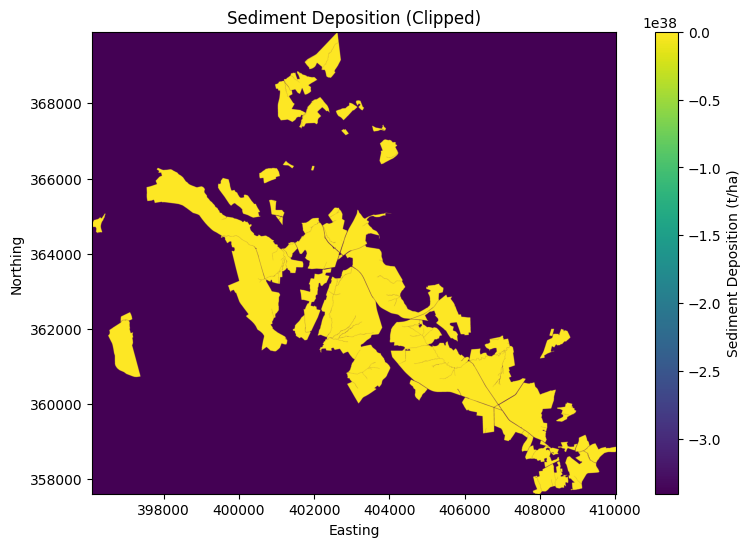

In [9]:
import matplotlib.pyplot as plt

# Layer to visualize
layer_to_plot = "../data/sdr/morridge/hires_lcm/tha_avoided_export_hr125sq.tif"

# Plot clipped layer
with rasterio.open(layer_to_plot) as src:
    clipped, transform = mask(src, boundary_geom, crop=True)
    clipped = clipped[0]

    plt.figure(figsize=(10, 6))
    plt.imshow(clipped, cmap="viridis", extent=(
        transform[2],
        transform[2] + transform[0] * clipped.shape[1],
        transform[5] + transform[4] * clipped.shape[0],
        transform[5]
    ))
    plt.colorbar(label="Sediment Deposition (t/ha)")
    plt.title("Sediment Deposition (Clipped)")
    plt.xlabel("Easting")
    plt.ylabel("Northing")
    plt.show()


In [10]:
# Mask NoData values
nodata = src.nodata
if nodata is None:
    nodata = -9999  # Define a fallback nodata value if not specified
clipped = np.ma.masked_equal(clipped, nodata)


In [11]:
# Replace extreme invalid values
clipped = np.where(clipped > 1e30, np.nan, clipped)


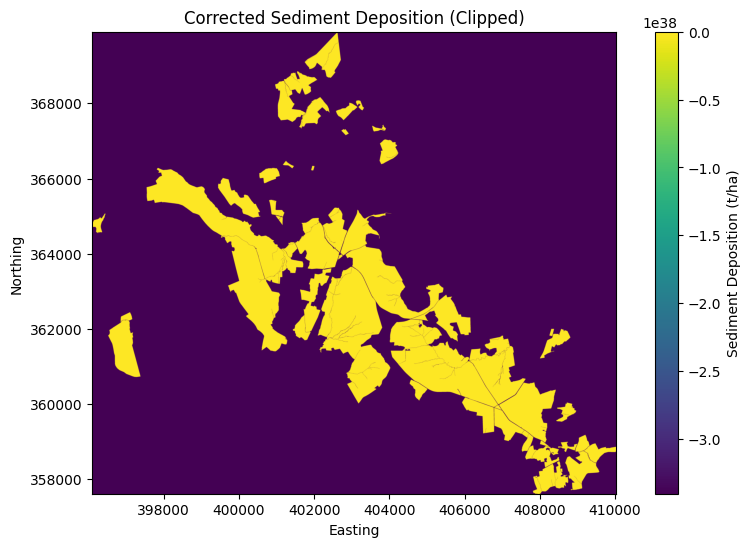

In [12]:
# Visualize corrected data
plt.figure(figsize=(10, 6))
plt.imshow(clipped, cmap="viridis", extent=(
    transform[2],
    transform[2] + transform[0] * clipped.shape[1],
    transform[5] + transform[4] * clipped.shape[0],
    transform[5]
))
plt.colorbar(label="Sediment Deposition (t/ha)")
plt.title("Corrected Sediment Deposition (Clipped)")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.show()


In [13]:
# Mask values based on thresholds
clipped = np.ma.masked_where((clipped < 0) | (clipped > 1e10), clipped)  # Adjust thresholds as needed


In [14]:
clipped

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=np.float64(1e+20),
  dtype=float32)